# Inteligência Artificial - Trabalho
- Universidade Federal de Santa Catarina
- Departamento de Automação e Sistemas
- Prof. Eric Aislan Antonelo

### Grupo
-

### Opção: 1

#### 1. Implementação:
- Crie as estruturas de dados para guardar os pesos que definem uma arquitetura
de rede neural multi-camadas. Inicialize a rede neural aleatoriamente.
- Implemente o algoritmo da retropropagação para o cálculo do gradiente, a
derivada parcial da função de custo com relação aos pesos da rede.
- Valide o algoritmo do cálculo do gradiente, realizando uma aproximação numérica
do mesmo. Verifique se os cálculos batem um com o outro.
- Dado o gradiente já calculado, implemente o método do descenso do gradiente
para o treinamento da rede neural, ou seja, o processo de ajuste dos pesos.

#### 2. Aplicação:
- Use o código implementado para treinar uma rede neural para realizar a classificação de um padrão de duas dimensões de entrada. Os dados para treinamento
estão disponíveis no arquivo
classification2.txt.
Para plotar a fronteira de decisão da rede treinada, poderá usar o código
disponível no link
https://colab.research.google.com/drive/1XTtZGgpAefbiWejTrEjsnWzS_
XXYdzff?usp=sharing.
- Relate resultados variando pelo menos duas vezes cada um dos hiperparâmetros: o número de camadas; o número de neurônios por camada; taxa de aprendizagem. Use métricas como taxa de classificação (porcentagem de predições
corretas) no conjunto de validação (exemplos não usados no treinamento).
- (opcional) Treine uma rede neural para classificar dígitos a partir de imagens
como entrada para a rede. Use o arquivo
classification3.mat.

#### 3. Entregas:
No relatório a ser entregue, descreva os experimentos e os resultados obtidos.
Grave um video de até 3 minutos, onde você deve explicar o código implementado
de uma forma geral, as dificuldades encontradas, e em especial:
- a parte do código referente ao cálculo do gradiente
- a parte do código referente ao gradient descent
- o gráfico da fronteira de decisão
Entregue o código, PDF do relatório e o arquivo de video pelo Moodle (zipado com
ZIP ou tar.gz).

In [1]:
import pandas as pd
import numpy as np
import sys
import logging
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from numpy import genfromtxt
from sklearn.preprocessing import StandardScaler

logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(message)s')

stdout_handler = logging.StreamHandler(sys.stdout)
stdout_handler.setFormatter(formatter)

logger.addHandler(stdout_handler)

logger.setLevel(logging.INFO)

### Data source

In [2]:
df = pd.read_csv('classification2.txt', header=None)
df.columns = ['column1', 'column2', 'label']
df.info()
print(f'\nLabel Value counts: \n{df.label.value_counts()}')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   column1  118 non-null    float64
 1   column2  118 non-null    float64
 2   label    118 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.9 KB

Label Value counts: 
0    60
1    58
Name: label, dtype: int64


,column1,column2,label
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


### Correlation Matrix

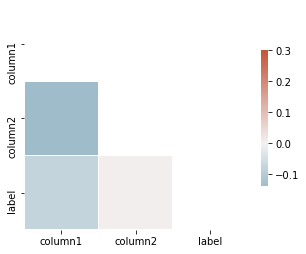

In [3]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    corr, mask=mask, cmap=cmap, vmax=.3, center=0,
    square=True, linewidths=.2, cbar_kws={"shrink": .5}
)
plt.show()

### Neural net data structure

In [ ]:
# To ADD / REMOVE bias
#self.input_length = input_length# + 1

#biased_input_data = np.ones((input_data.shape[0], input_data.shape[1] + 1))
#biased_input_data[:, :-1] = input_data

#next_activation = np.append(next_activation, 1)

#previous_deltas = new_deltas[:-1] # Exclude bias delta

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x)) 

def sigmoid_derivative(x):
    return x * (1 - x)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    x[x <= 0] = 0
    x[x > 0] = 1
    return x

class Neuron():
    def __init__(self, input_length):
        self.__weights = self.create_random_weights(input_length)
        
    def create_random_weights(self, input_length):
        return np.random.uniform(-0.5, 0.5, input_length)
        
    @property
    def weights(self):
        return self.__weights
    
    @weights.setter
    def weights(self, new_value):
        self.__weights = new_value
    
    def __repr__(self):
        return f'Neuron {self.weights}'
    
class Layer():
    def __init__(self, input_length, n_neurons):
        self.input_length = input_length + 1 # input_length + bias_length
        self.n_neurons = n_neurons
        self.create_neurons()
        self.dd = np.zeros((self.n_neurons, self.input_length))
    
    def create_neurons(self):
        """Creates neurons of layer
        """
        self.neurons = list()
        for i in range(self.n_neurons):
            self.neurons.append(
                Neuron(self.input_length)
            )
            
    def __repr__(self):
        return f'Layer \n{self.weights_matrix}'
    
    @property
    def weights_matrix(self):
        """Represents layer's weights as a matrix, where each column is a neuron.
        """
        return np.array([n.weights for n in self.neurons])
    
    @weights_matrix.setter
    def weights_matrix(self, new_weights):
        for neuron_i, neuron in enumerate(self.neurons):
            neuron.weights = new_weights[neuron_i]
            
    def transform(self, input_data, activation_function):
        """Calculates layer output based on input data
        """
        
        # Include bias
        biased_input_data = np.ones((input_data.shape[0], input_data.shape[1] + 1))
        biased_input_data[:, :-1] = input_data
        
        self.z = np.dot(biased_input_data, self.weights_matrix.T)

        self.activation = activation_function(self.z)
        return self.activation

class NeuralNet():
    def __init__(self, *layers, learning_rate=0.1, epochs=5,
                 activation_function=relu, der_activation_function=relu_derivative,
                 last_layer_activation_function=sigmoid, last_layer_der_activation_function=sigmoid_derivative,
                ):
        self.layers = layers
        self.learning_rate = learning_rate
        self.costs = list()
        self.epochs = epochs
        self.activation_function = activation_function
        self.der_activation_function = der_activation_function
        self.last_layer_activation_function = last_layer_activation_function
        self.last_layer_der_activation_function = last_layer_der_activation_function
    
    def transform(self, X):
        X_transformed = X.copy()
        for layer in self.layers[:-1]:
            X_transformed = layer.transform(X_transformed, activation_function=self.activation_function)

        X_transformed = self.layers[-1].transform(
            X_transformed,
            activation_function=self.last_layer_activation_function
        )
        return X_transformed
    
    def __repr__(self):
        return f'Neural Net \n{self.weights_matrix}'
    
    @property
    def weights_matrix(self):
        """Represents layer's weights as a matrix, where each column is a neuron.
        """
        return np.array([l.weights_matrix for l in self.layers], dtype=object)

    @weights_matrix.setter
    def weights_matrix(self, new_weights):
        for layer_i, layer in enumerate(self.layers):
            layer.weights_matrix = new_weights[layer_i]
    
    def cost(self, X, y):
        hx = self.transform(X)
        
        log1_hx = np.log(hx)
        log2_hx = np.log(1 - hx)
        
        y_1 = y * log1_hx
        y_0 = (1 - y) * log2_hx

        return -np.sum(
            y_1 + y_0
        ) / X.shape[0]
    
    def has_next_item(self, list_, index_):
        return (index_ + 1) != len(list_)

    def backpropagate(self, X, hx, y):
        loss_der =  np.divide(1 - y, np.maximum(1 - hx, 0.00001)) - np.divide(y, np.maximum(hx, 0.00001))
        
        reversed_layers = self.layers[::-1]
        
        deltas = self.last_layer_der_activation_function(hx) * loss_der
        
        for layer_i, layer in enumerate(reversed_layers):
            if layer_i > 0:
                deltas = np.dot(
                    deltas,
                    reversed_layers[layer_i-1].weights_matrix[:, :-1],
                ) * self.der_activation_function(next_activation)
                
            if self.has_next_item(reversed_layers, layer_i):
                next_activation = reversed_layers[layer_i + 1].activation
            else:
                next_activation = X
        
            next_activation_biased = np.append(
                next_activation,
                np.ones(
                    next_activation.shape[0]
                ).reshape((next_activation.shape[0], 1)),
                axis=1
            )

            weights_der = np.dot(next_activation_biased.T, deltas)
            
            layer.new_weights_matrix = layer.weights_matrix - self.learning_rate * weights_der.T / len(X)
        
    def update_weights(self):
        for layer in self.layers:
            layer.weights_matrix = layer.new_weights_matrix
            
    def plot_cost(self):
        plt.plot(self.costs)
        plt.title('Cross entrophy cost')
        plt.ylabel('Cost')
        plt.xlabel('Epoch')
        plt.show()
        
    def fit(self, X, y):
        logger.info(f'Fitting')
        for epoch in range(self.epochs):
            hx = self.transform(X)
            loss = self.cost(X, y)
            self.backpropagate(X, hx, y)
            self.update_weights()
            self.costs.append(loss)
            
            if epoch % 500 == 0:
                logger.info(f'Running epoch {epoch}')
                self.plot_cost()
                plot_boundary_frontier(X, y.ravel(), title="Boundary Frontier for epoch {}".format(epoch))
            
        self.plot_cost()
        plot_boundary_frontier(X, y.ravel(), title="Boundary Frontier for epoch {}".format(epoch))
        
def print_metrics(y, preds):
    print(f'F1 : {f1_score(y, preds)}')
    print(f'Accuracy: {accuracy_score(y, preds)}')

def plot_outputs(X, y, title=None):
    plt.scatter(X[y==1,0],X[y==1,1], c="r", marker="+")
    plt.scatter(X[y==0,0],X[y==0,1], c="g", marker="o")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend(["1","0"],loc=0)
    plt.title(title)
    plt.show()
    
def plot_boundary_frontier(X, y, title=None, h=0.02):
    cmap_light = ListedColormap(['#B8FFCB', '#FFAAAA'])

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = nn.transform(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.round().reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plot_outputs(X, y, title)

    

# Define dataset and train model

Fitting
Running epoch 0


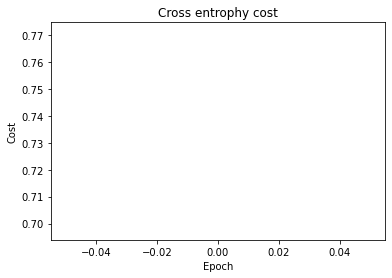

<ipython-input-4-cc176972f7af>:217: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


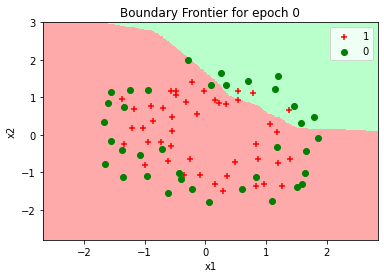

Running epoch 500


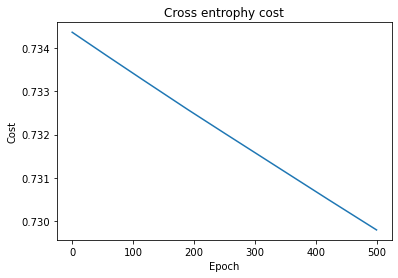

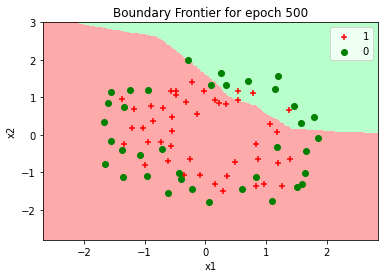

Running epoch 1000


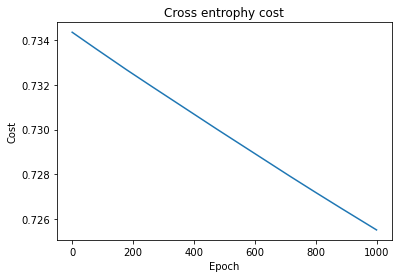

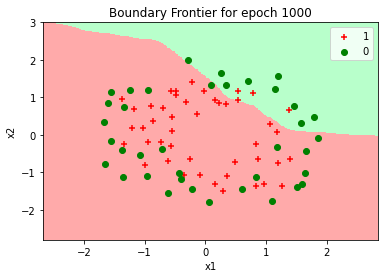

Running epoch 1500


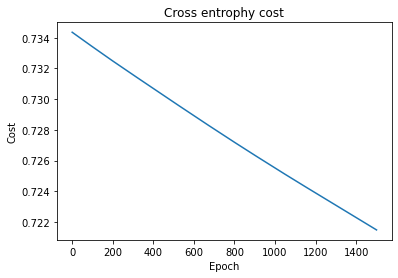

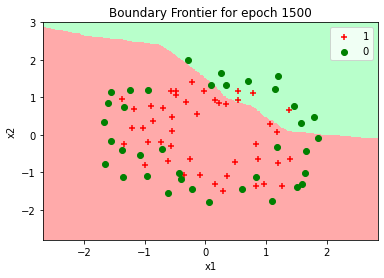

Running epoch 2000


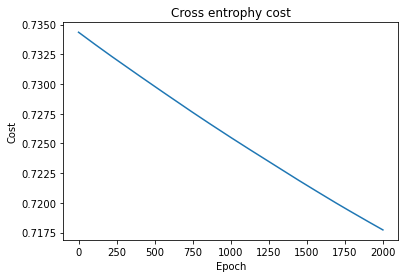

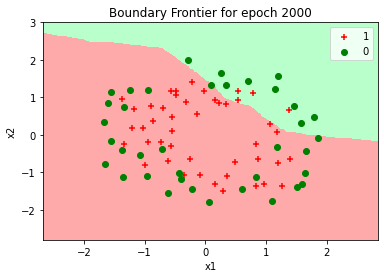

Running epoch 2500


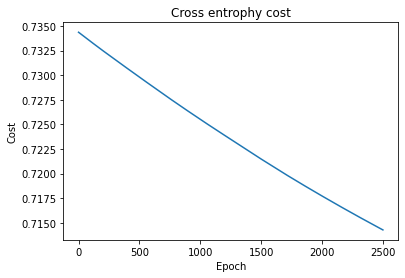

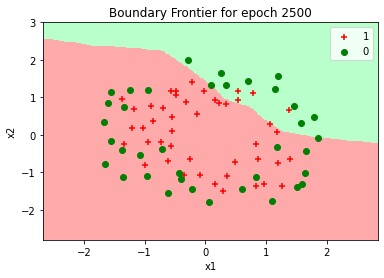

Running epoch 3000


In [ ]:
# Define features and label
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1]
y = y.values.reshape(y.shape[0], 1)

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Standardize
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

# Define model's layers
hidden_layer_sizes = [30, 20]
layers = [
    Layer(input_length=X_train.shape[1], n_neurons=hidden_layer_sizes[0]),
    Layer(input_length=hidden_layer_sizes[0], n_neurons=hidden_layer_sizes[1]),
    Layer(input_length=hidden_layer_sizes[1], n_neurons=1),
]

# Instantiate model
epochs = 10000

nn = NeuralNet(
    *layers, learning_rate=0.0001, epochs=epochs,
)

# Train model
nn.fit(X_train, y_train)
nn_preds = nn.transform(X_test)
nn_preds_round = nn_preds.round()

## Train and evaluate sklearn models for comparison

In [6]:
cls = LogisticRegression()
cls.fit(X_train, y_train.ravel())
lr_preds = cls.predict(X_test)

cls = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=epochs)
cls.fit(X_train, y_train.ravel())
mlp_preds = cls.predict(X_test)

# Evaluate models

#### Real Labels

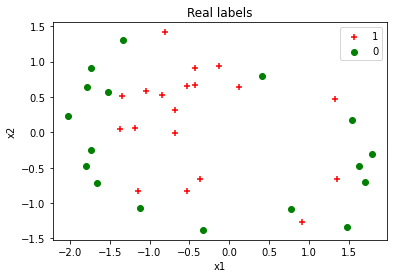

In [7]:
plot_outputs(X_test, y_test.ravel(), title='Real labels')

#### NeuralNet Predictions

F1 : 0.787878787878788
Accuracy: 0.8055555555555556


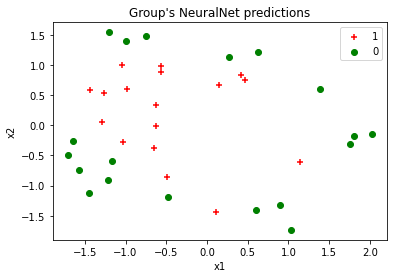

<ipython-input-4-cc176972f7af>:217: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


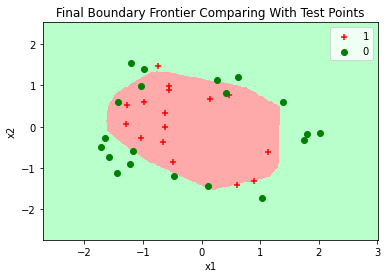

In [12]:
print_metrics(y_test, nn_preds_round)
plot_outputs(X_test, nn_preds_round.ravel(), title="Group's NeuralNet predictions")
plot_boundary_frontier(X_test, y_test.ravel(), title="Final Boundary Frontier Comparing With Test Points")

#### Sklearn LogisticRegression predictions

F1 : 0.5853658536585366
Accuracy: 0.5277777777777778


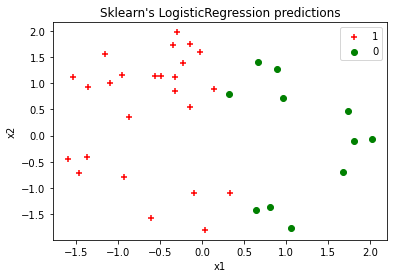

In [128]:
print_metrics(y_test.ravel(), lr_preds)
plot_outputs(X_test, lr_preds, title="Sklearn's LogisticRegression predictions")

#### Sklearn MLPClassifier predictions

F1 : 0.7999999999999999
Accuracy: 0.8333333333333334


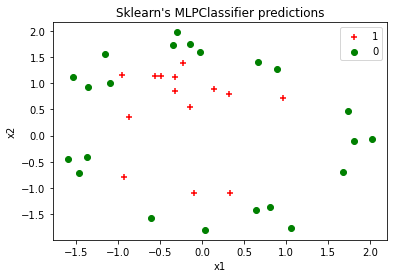

In [129]:
print_metrics(y_test.ravel(), mlp_preds)
plot_outputs(X_test, mlp_preds, title="Sklearn's MLPClassifier predictions")

#### Fronteira de decisão não linear

In [56]:
print(X)
print(np.array([[1, 3]]))
print(nn_preds)
# print(X[:, 0])

[[ 0.051267   0.69956  ]
 [-0.092742   0.68494  ]
 [-0.21371    0.69225  ]
 [-0.375      0.50219  ]
 [-0.51325    0.46564  ]
 [-0.52477    0.2098   ]
 [-0.39804    0.034357 ]
 [-0.30588   -0.19225  ]
 [ 0.016705  -0.40424  ]
 [ 0.13191   -0.51389  ]
 [ 0.38537   -0.56506  ]
 [ 0.52938   -0.5212   ]
 [ 0.63882   -0.24342  ]
 [ 0.73675   -0.18494  ]
 [ 0.54666    0.48757  ]
 [ 0.322      0.5826   ]
 [ 0.16647    0.53874  ]
 [-0.046659   0.81652  ]
 [-0.17339    0.69956  ]
 [-0.47869    0.63377  ]
 [-0.60541    0.59722  ]
 [-0.62846    0.33406  ]
 [-0.59389    0.005117 ]
 [-0.42108   -0.27266  ]
 [-0.11578   -0.39693  ]
 [ 0.20104   -0.60161  ]
 [ 0.46601   -0.53582  ]
 [ 0.67339   -0.53582  ]
 [-0.13882    0.54605  ]
 [-0.29435    0.77997  ]
 [-0.26555    0.96272  ]
 [-0.16187    0.8019   ]
 [-0.17339    0.64839  ]
 [-0.28283    0.47295  ]
 [-0.36348    0.31213  ]
 [-0.30012    0.027047 ]
 [-0.23675   -0.21418  ]
 [-0.06394   -0.18494  ]
 [ 0.062788  -0.16301  ]
 [ 0.22984   -0.41155  ]
